In [4]:
## Create song paths
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import librosa
import IPython
from scipy.io import loadmat

dataset_path = '/Users/apple/Downloads/Bach10/'
def create_song_paths(dataset_path):
    song_paths=[]
    for song_name in os.listdir(dataset_path) :
        if (song_name != '.DS_Store') : song_paths.append(dataset_path + song_name + '/')
    return sorted(song_paths)

song_paths = create_song_paths(dataset_path)
#print(song_paths)

## Create mats_and_wavs
list_of_instruments = ['Violin', 'Clarinet', 'Saxophone','Bassoon']
def create_mats_and_wavs(dataset_path, song_paths):
    mats_and_wavs = [[] for k in range(len(song_paths))]
    length = len(dataset_path)
    for i in range(len(song_paths)):
        mats_and_wavs[i].append(song_paths[i]+song_paths[i][length:-1]+'-violin.wav')
        mats_and_wavs[i].append(song_paths[i]+song_paths[i][length:-1]+'-clarinet.wav')
        mats_and_wavs[i].append(song_paths[i]+song_paths[i][length:-1]+'-saxphone.wav')
        mats_and_wavs[i].append(song_paths[i]+song_paths[i][length:-1]+'-bassoon.wav')
        mats_and_wavs[i].append(song_paths[i]+song_paths[i][length:-1]+'.wav')
        mats_and_wavs[i].append(song_paths[i]+song_paths[i][length:-1]+'-GTF0s.mat') 
    return mats_and_wavs

mats_and_wavs = create_mats_and_wavs(dataset_path, song_paths)
print(mats_and_wavs[9][4])

## Read wavfile for a single song 
song, sample_rate = librosa.load(mats_and_wavs[9][4])
IPython.display.Audio(data = song, rate = sample_rate)
# sample_rate = 22050

/Users/apple/Downloads/Bach10/10-NunBitten/10-NunBitten.wav


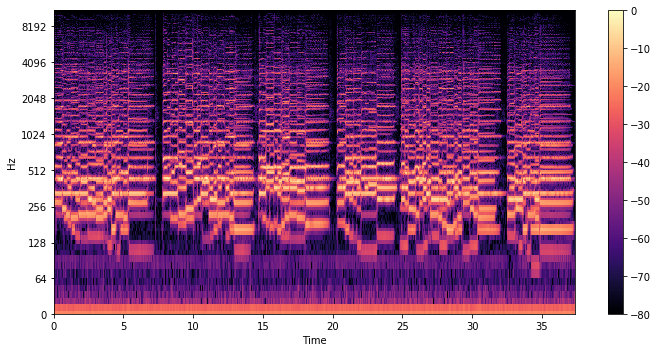

In [5]:
## Plot spectrogram for a single complete song
window_size = int(0.084*sample_rate)
hop_size = int(0.01*sample_rate)
Stft = librosa.stft(song, n_fft = window_size, hop_length=hop_size)
Vft, phase = librosa.magphase(Stft)
#Plot
plt.figure(figsize=(10,5))
librosa.display.specshow(librosa.amplitude_to_db(Vft,ref=np.max), x_axis='time', y_axis='log', 
                        sr=sample_rate, hop_length=hop_size)
plt.colorbar()
plt.tight_layout()

In [6]:
## Define a function to lose information from a matrix
def create_reduced_matrix(matrix):
    S = len(matrix)
    T = len(matrix[0])
    reduced_matrix = [[] for k in range(T)]
    #print(reduced_matrix)
    for i in range(T):
        for j in range(S):
            if (matrix[j][i]>0) : reduced_matrix[i].append(matrix[j][i])
        reduced_matrix[i] = sorted(reduced_matrix[i])
    return reduced_matrix

x=[[10,0],[30,0],[15,25],[0,40]]
z = create_reduced_matrix(x)
print(z)
# z[i] empty when no instrument is playing

[[10, 15, 30], [25, 40]]


In [8]:
## Load Pt_fbypa
directory = '/Users/apple/Downloads/store/'
def filepath(filename):
    global directory
    return directory+filename

Pt_pszabyf = np.load(filepath('Pt_pszabyf_')+str(0)+'.npy')
print(Pt_pszabyf.shape)
# print(np.max(Pt_pszabyf), np.min(Pt_pszabyf)) 
T,F,P,S,Z,A = Pt_pszabyf.shape

(2519, 172, 4, 4, 3, 7)


In [11]:
## Create the Data Loader

# Create a list of reduced matrices
def create_list_of_reduced_matrices(mats_and_wavs):
    global T
    list_of_reduced_matrices = []
    for i in range(len(mats_and_wavs)):
        matrix = np.array(loadmat(mats_and_wavs[i][5])['GTF0s']).astype('int')
        T = min(T, matrix.shape[1])
        reduced_matrix = create_reduced_matrix(matrix)
        list_of_reduced_matrices.append(reduced_matrix)
    return np.array(list_of_reduced_matrices)


# Create a list of Pt_fbys
def create_list_of_Vft(song_paths, mats_and_wavs):
    global window_size, hop_size, F, T
    list_of_Vft = []
    for song_path_index in range(len(song_paths)):
        song, sample_rate = librosa.load(mats_and_wavs[song_path_index][4])
        Stft = librosa.stft(song, n_fft=window_size, hop_length=hop_size)
        Vft, phase = librosa.magphase(Stft)
        Vft = Vft[:F, :T]
        for t in range(T): Vft[:, t] = Vft[:, t]/sum(Vft[:, t])
        #for s in range(S): Pt_f.append(Vft)
        list_of_Vft.append(Vft)
    return np.array(list_of_Vft)


# list_of_red_mat = create_list_of_reduced_matrices(mats_and_wavs)
# list_of_Vft = create_list_of_Vft(song_paths, mats_and_wavs)
#np.save(filepath('list_of_red_mat')+'.npy', list_of_red_mat)
# np.save(filepath('list_of_Vft')+'.npy', list_of_Vft)
list_of_red_mat = np.load(filepath('list_of_red_mat')+'.npy')
list_of_Vft = np.load(filepath('list_of_Vft')+'.npy')


# Create a function to return a one hot vector corresponding to the source at a given p and t
from tensorflow.keras.utils import to_categorical
def one_hot_output(mats_and_wavs, song_path_index, t, p):
    global S
    matrix = np.array(loadmat(mats_and_wavs[song_path_index][5])['GTF0s']).astype('int')
    count=0
    array = sorted(matrix[:,t])
    for s in range(S):
        if array[s]==0 : continue
        else : 
            if p==count : break
            else : count+=1           
    if s<S : 
        label = np.array([s])
        label = to_categorical(label, num_classes = S)
        return label

In [12]:
## Define a function to sum over 'F' axis
def sum_over_f(t, Vft, Pt_pszabyf):
    x = Vft[:,t]
    x = np.reshape(x, list(x.shape)+[1,1,1,1])
    # [172,1,1,1,1]
    y = Pt_pszabyf[t,:,:,:,:,:]
    # [172,4,4,3,7]
    z = x*y
    # [172,4,4,3,7]
    z = np.sum(z, 0)
    # [4,4,3,7]
    return z

In [13]:
# Create generator
def generator(list_of_songs, batch_size):
    global list_of_red_mat, list_of_Vft, T, A, F
    iterate=0
    while True:
        #print(iterate)
        for song_path_index in list_of_songs :
            red_mat = list_of_red_mat[song_path_index]
            Vft = list_of_Vft[song_path_index]
            Pt_pszabyf = np.load(filepath('Pt_pszabyf_'+str(song_path_index))+'.npy')
            # shape of Vft is [F,T], shape of Pt_pszabyf is [T,F,P,S,Z,A]
            batch=0
            for t in range(T):
                Vft_Pt_pszabyf_t = sum_over_f(t, Vft, Pt_pszabyf)
                # shape of Vft_Pt_pszabyf_t is [P,S,Z,A]
                for p in range(len(red_mat[t])):
                    if batch<batch_size:
                        inputs = Vft_Pt_pszabyf_t[p,:,:,:]
                        # shape of inputs is [S,Z,A]
                        inputs = np.swapaxes(inputs,0,2)
                        inputs = np.swapaxes(inputs,1,2)
                        # shape of inputs is [A,S,Z]
                        inputs = np.reshape(inputs, [1]+list(inputs.shape))
                        # shape of inputs is [1,A,S,Z]
                        outputs = one_hot_output(mats_and_wavs, song_path_index, t, p)
                        # shape of outputs is [1,S]
                        if batch==0 : 
                            batch_inputs = inputs
                            batch_outputs = outputs
                        else : 
                            batch_inputs = np.concatenate((batch_inputs, inputs), axis=0)
                            batch_outputs = np.concatenate((batch_outputs, outputs), axis=0)
                        #print(batch_input1.shape, batch_input2.shape, batch_outputs.shape)
                        batch+=1
                    else : 
                        batch=0
                        yield (batch_inputs, batch_outputs)
        #iterate+=1
        
list_of_train_songs = [0,1,3,4,5,6,7,9]
list_of_val_songs = [2,8]

def total_examples(list_of_songs):
    total=0
    for song_index in list_of_songs:
        for i in range(len(list_of_red_mat[song_index])):
            total+=len(list_of_red_mat[song_index][i])
    return total

train_samples = total_examples(list_of_train_songs)
val_samples = total_examples(list_of_val_songs)
print(train_samples)
print(val_samples)
train_generator = generator(list_of_train_songs, 32)
val_generator = generator(list_of_val_songs, 16)

99108
19640


In [23]:
## Define custom model     
import tensorflow as tf  
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, BatchNormalization
from tensorflow.keras.regularizers import l2

class custom_model(tf.keras.Model):
    global S,Z,A
    def __init__(self):
        super(custom_model,self).__init__()
        self.conv1=Conv2D(input_shape=(A,S,Z), filters=2*Z, kernel_size=(3,3), 
                          strides=(1,1), activation = 'relu',
                          kernel_regularizer=l2(0.001))
        self.bn1=BatchNormalization(axis=-1)
        self.conv2=Conv2D(filters=3*Z, kernel_size=(2,2), strides = (1,1), activation = 'relu',
                          kernel_regularizer=l2(0.001))
        self.bn2=BatchNormalization(axis=-1)
        self.flatten=Flatten()
        self.dense1=Dense(S, activation = 'softmax', kernel_regularizer=l2(0.001))
    
    def call(self, inputs):
        Vft_Pt_psazabyf_given_tp = inputs
        #print(Vft_Pt_psazabyf_given_tp.shape)
        x=self.conv1(Vft_Pt_psazabyf_given_tp)
        x=self.bn1(x)
        x=self.conv2(x)
        x=self.bn2(x)
        x=self.flatten(x)
        x=self.dense1(x)
        #print(x.shape)
        return x

model = custom_model()
# Compile
from tensorflow.keras.optimizers import Adam
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['mae', 'acc'])

# Train
model.fit_generator(generator = train_generator, epochs = 1, steps_per_epoch = train_samples/32, 
                    validation_data = val_generator, validation_steps = val_samples/16,
                    verbose = 1, shuffle = True)

3098/3097 [==============================] - 174s 56ms/step - loss: 1.1470 - mae: 0.3291 - acc: 0.4335 - val_loss: 1.2331 - val_mae: 0.3131 - val_acc: 0.5011
